In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
import numpy as np

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
words = open('names.txt', 'r').read().splitlines()

--2023-09-30 20:45:57--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2023-09-30 20:45:58 (9.47 MB/s) - ‘names.txt’ saved [228145/228145]



In [4]:
# Vocabulary Building
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

In [5]:
# Define the block size for character-level modeling.
block_size = 3

# Function to build the dataset for character-level prediction.
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size  # Initialize the context with zeros.
        for ch in w + '.':  # Iterate through each character in the word and add a period ('.') at the end.
            ix = stoi[ch]  # Convert the character to an index using a dictionary 'stoi'.

            # Append the context to the input data 'X' and the index of the current character to the target data 'Y'.
            X.append(context)
            Y.append(ix)

            # Update the context by shifting it to the left and adding the index of the current character.
            context = context[1:] + [ix]

    # Convert the lists 'X' and 'Y' into PyTorch tensors.
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

# Split the dataset into training, development, and testing sets based on the word indices.
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# Create training, development, and testing datasets using the 'build_dataset' function.
Xtr, Ytr = build_dataset(words[:n1])  # Training set
Xdev, Ydev = build_dataset(words[n1:n2])  # Development set
Xte, Yte = build_dataset(words[n2:])  # Testing set


In [8]:
import torch.nn as nn

# Define a class for the Multi-Layer Perceptron model.
class MLP(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden):
        super(MLP, self).__init__()

        # Embedding layer to convert character indices to embeddings.
        self.embedding = nn.Embedding(vocab_size, n_embd)

        # Define the layers of the MLP using a Sequential container.
        self.layers = nn.Sequential(
            nn.Linear(n_embd * block_size, n_hidden, bias=False),  # Fully connected layer with no bias.
            nn.BatchNorm1d(n_hidden),  # Batch normalization to stabilize training.
            nn.Tanh(),  # Hyperbolic tangent activation function.

            # Repeat the following layers several times for depth in the network.
            nn.Linear(n_hidden, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.Tanh(),

            # Output layer with a linear transformation to predict character indices.
            nn.Linear(n_hidden, vocab_size, bias=False),
            nn.BatchNorm1d(vocab_size)
        )
    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x


In [9]:
# Function to train the MLP model.
def train(model, X, Y, max_steps, batch_size, lr_initial=0.1, lr_decay_step=150000):
    # Define the optimizer and loss function.
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_initial)
    criterion = nn.CrossEntropyLoss()

    # Lists to store loss and gradient information during training.
    lossi = []
    ud = []

    for i in range(max_steps):
        # Randomly sample a batch of data from the training set.
        ix = torch.randint(0, X.size(0), (batch_size,))
        Xb, Yb = X[ix], Y[ix]

        # Zero the gradients.
        optimizer.zero_grad()

        # Forward pass through the model.
        outputs = model(Xb)

        # Calculate the loss.
        loss = criterion(outputs, Yb)

        # Backpropagate the gradients and update the model's weights.
        loss.backward()
        optimizer.step()

        # Learning rate decay after a certain number of steps.
        lr = lr_initial if i < lr_decay_step else 0.01
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Print loss at regular intervals during training.
        if i % 10000 == 0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.item())

        # Compute and log the ratio of gradient magnitude to parameter magnitude (log10 scale).
        with torch.no_grad():
            ud.append([((lr * p.grad).std() / p.data.std()).log10().item() for p in model.parameters()])

    # Return the training loss history and gradient history.
    return lossi, ud

# Create an instance of the MLP model.
model = MLP(vocab_size, n_embd=10, n_hidden=100)

# Train the model and collect loss and gradient information.
loss_history, gradient_history = train(model, Xtr, Ytr, max_steps=200000, batch_size=32)


      0/ 200000: 3.9400
  10000/ 200000: 2.7374
  20000/ 200000: 2.1272
  30000/ 200000: 2.1124
  40000/ 200000: 2.2158
  50000/ 200000: 2.0817
  60000/ 200000: 2.0434
  70000/ 200000: 1.6658
  80000/ 200000: 2.1720
  90000/ 200000: 2.3358
 100000/ 200000: 2.2948
 110000/ 200000: 2.0754
 120000/ 200000: 1.7298
 130000/ 200000: 2.0491
 140000/ 200000: 2.2108
 150000/ 200000: 2.2799
 160000/ 200000: 2.0413
 170000/ 200000: 2.2210
 180000/ 200000: 2.1233
 190000/ 200000: 2.0026


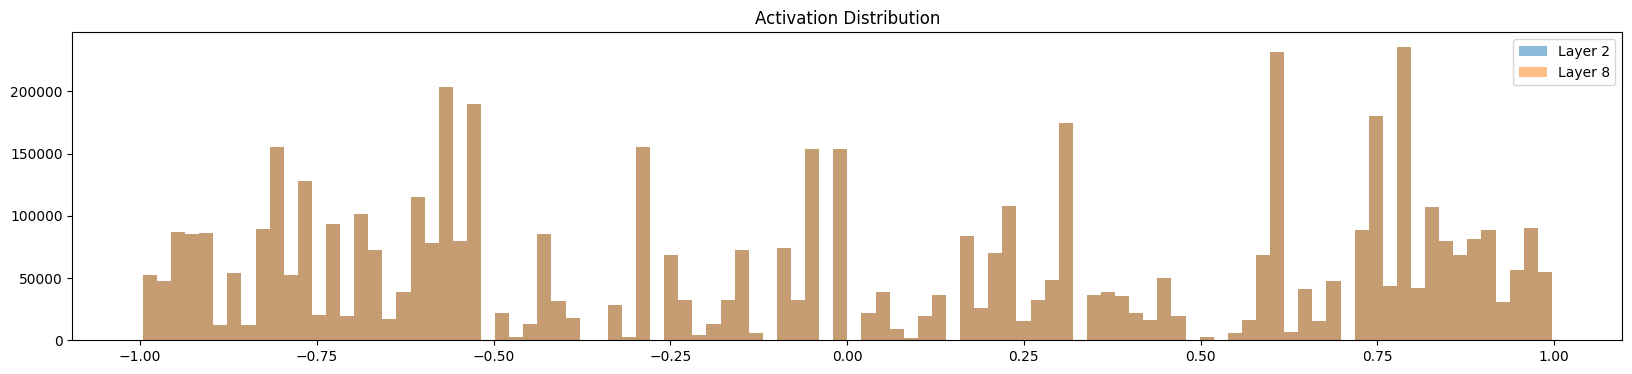

In [13]:
# Visualization - Activation Distributions
def plot_activation_distribution(model, X, layer_indices):
    plt.figure(figsize=(20, 4))
    legends = []
    for i, layer in enumerate(model.layers):
        if i in layer_indices and isinstance(layer, nn.Tanh):
            with torch.no_grad():
                out = layer(model.embedding(X)).view(-1).numpy()
                mean = out.mean()
                std = out.std()
                saturated = (np.abs(out) > 0.97).mean() * 100
                plt.hist(out, bins=100, alpha=0.5, label=f'Layer {i}, Mean={mean:.2f}, Std={std:.2f}, Saturated={saturated:.2f}%')
                legends.append(f'Layer {i}')
    plt.legend(legends)
    plt.title('Activation Distribution')

plot_activation_distribution(model, Xtr, [2, 4, 6, 8])

In [14]:
# Evaluation
def evaluate(model, X, Y):
    with torch.no_grad():
        outputs = model(X)
        loss = F.cross_entropy(outputs, Y)
    return loss.item()

print(f"Train Loss: {evaluate(model, Xtr, Ytr):.4f}")
print(f"Validation Loss: {evaluate(model, Xdev, Ydev):.4f}")
print(f"Test Loss: {evaluate(model, Xte, Yte):.4f}")

Train Loss: 1.9565
Validation Loss: 2.2999
Test Loss: 2.3380


Further improvements:
Fine-tune hyperparameters such as n_embd, n_hidden, and learning rates.
Experiment with different architectures or regularization techniques.